In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import os

## Without oversampling

In [2]:
df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
categorical = df[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].idxmax(axis=1).values
df['name'] = df['image'].map(lambda x: '{}.jpg'.format(x))
df['label'] = categorical
df.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'image', 'UNK'], axis=1, inplace=True)
df.drop
df.head()

,name,label
0,ISIC_0000000.jpg,NV
1,ISIC_0000001.jpg,NV
2,ISIC_0000002.jpg,MEL
3,ISIC_0000003.jpg,NV
4,ISIC_0000004.jpg,MEL


In [5]:
#skip this cell
#just checking if the transforms applied makes sense
#def get_ex(): return open_image('C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\ISIC2018_Task3_Training_Input\\ISIC_0024306.jpg')

#def plots_f(rows, cols, width, height, **kwargs):
#    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
#        rows,cols,figsize=(width,height))[1].flatten())]
    
#tfms = get_transforms(flip_vert=True, max_zoom=1)
#plots_f(2, 4, 12, 6, size=224)

In [3]:
tfms = get_transforms(flip_vert=True, max_zoom=1, max_lighting = None)
path = 'ISIC_2019_Training_Input/'
data = (ImageList.from_df(df, path)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_df()
       .transform(tfms, size = 299)
       .databunch()
       .normalize(imagenet_stats))

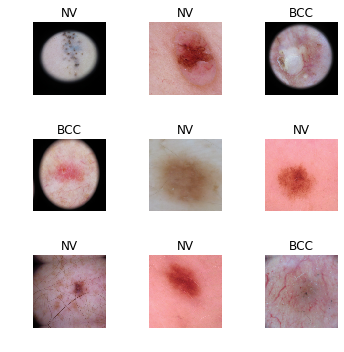

In [4]:
data.show_batch(rows=3, figsize=(5,5))

## Training Resnet18

In [8]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data,models.resnet18,metrics=[accuracy,Precision(),Recall()],callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


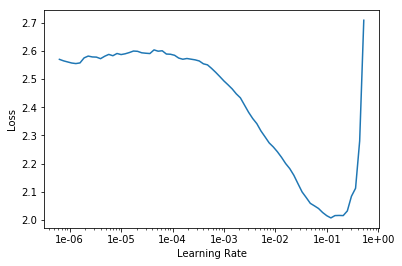

In [6]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.105282,0.898954,0.677852,0.515934,0.340316,04:40
1,0.937316,0.799581,0.710028,nan,0.409470,04:39
2,0.850614,0.750202,0.730951,0.638287,0.472013,04:40
3,0.807686,0.721474,0.730951,0.610817,0.495049,04:40
4,0.751536,0.696600,0.743387,0.645698,0.511009,04:37
5,0.738478,0.685840,0.744374,0.661607,0.536840,04:39
6,0.748572,0.671370,0.758587,0.661338,0.565082,04:38
7,0.733637,0.666829,0.760758,0.701102,0.545223,04:39
8,0.725674,0.699063,0.742993,0.688007,0.524253,04:38
9,0.704055,0.681349,0.755823,0.638213,0.531971,04:37


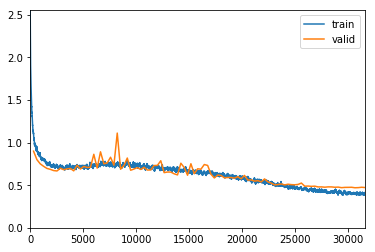

Better model found at epoch 0 with recall value: 0.3403155207633972.
Better model found at epoch 1 with recall value: 0.4094696342945099.
Better model found at epoch 2 with recall value: 0.4720131456851959.
Better model found at epoch 3 with recall value: 0.4950491786003113.
Better model found at epoch 4 with recall value: 0.5110092759132385.
Better model found at epoch 5 with recall value: 0.5368397235870361.
Better model found at epoch 6 with recall value: 0.5650820732116699.
Better model found at epoch 10 with recall value: 0.6159496903419495.
Better model found at epoch 46 with recall value: 0.6190639138221741.
Better model found at epoch 54 with recall value: 0.6244015693664551.
Better model found at epoch 56 with recall value: 0.653721034526825.
Better model found at epoch 57 with recall value: 0.6585134267807007.
Better model found at epoch 64 with recall value: 0.6779018640518188.
Better model found at epoch 66 with recall value: 0.6934443712234497.
Better model found at epoch 

In [9]:
lr = 1e-2
learn.fit_one_cycle(100,lr, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='recall', name='stage-1')])

In [10]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
NV,NV,MEL,NV,MEL
Path: ISIC_2019_Training_Input;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
BKL,BCC,NV,NV,MEL
Path: ISIC_2019_Training_Input;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Fine Tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


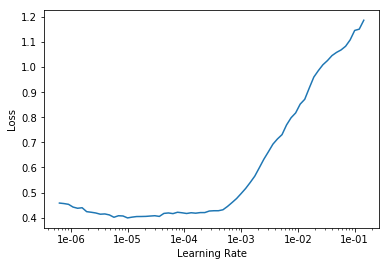

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.406088,0.471926,0.841887,0.816912,0.729654,04:39
1,0.408133,0.473181,0.840703,0.810944,0.728993,04:39
2,0.402830,0.470050,0.841690,0.804051,0.745877,04:38
3,0.407097,0.471626,0.841690,0.810931,0.735662,04:42
4,0.402824,0.473446,0.842282,0.822676,0.737113,04:38
5,0.415399,0.467722,0.843664,0.810007,0.745519,04:39
6,0.405959,0.469446,0.842084,0.811838,0.738257,04:36
7,0.398312,0.467249,0.838729,0.810841,0.729960,04:37
8,0.398413,0.466200,0.842479,0.815449,0.734680,04:38
9,0.410058,0.471861,0.841098,0.817170,0.722374,04:38


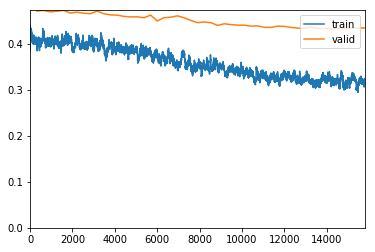

Better model found at epoch 0 with recall value: 0.7296537160873413.
Better model found at epoch 2 with recall value: 0.745876669883728.
Better model found at epoch 16 with recall value: 0.7481269240379333.
Better model found at epoch 18 with recall value: 0.7485007643699646.
Better model found at epoch 19 with recall value: 0.7521407008171082.
Better model found at epoch 24 with recall value: 0.7531169652938843.
Better model found at epoch 29 with recall value: 0.7559593915939331.
Better model found at epoch 31 with recall value: 0.7629619836807251.
Better model found at epoch 42 with recall value: 0.7647842168807983.


In [12]:
learn.unfreeze()
learn.fit_one_cycle(50, max_lr = slice(1e-6,1e-4),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='recall', name='stage-2')])

In [13]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
NV,NV,MEL,NV,MEL
Path: ISIC_2019_Training_Input;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
BKL,BCC,NV,NV,MEL
Path: ISIC_2019_Training_Input;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

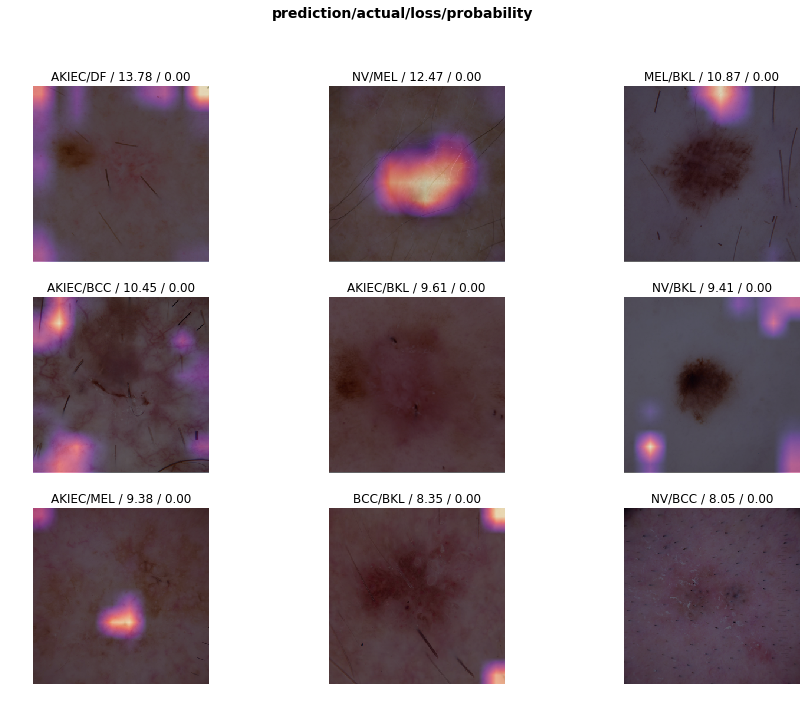

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

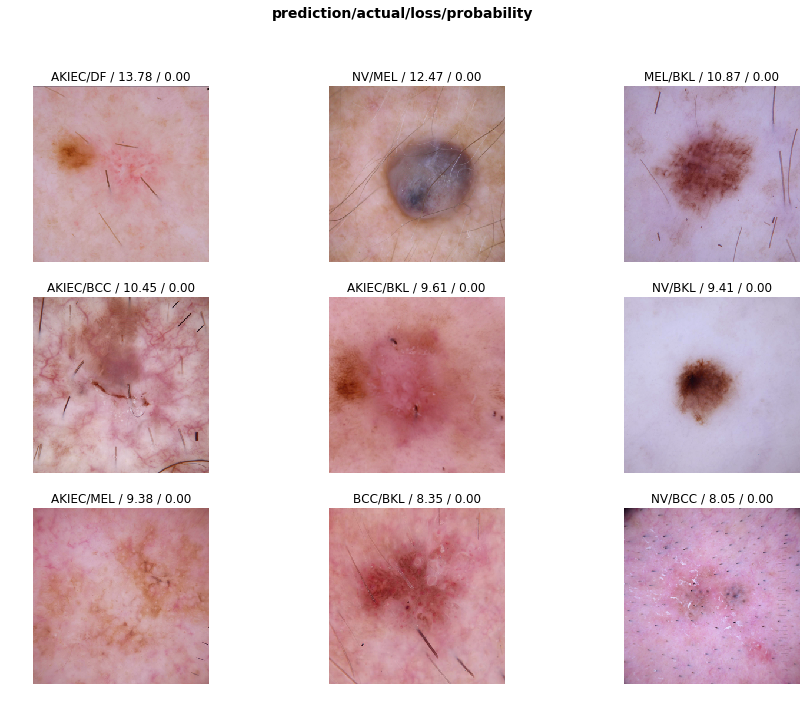

In [21]:
interp.plot_top_losses(9, figsize=(15,11),heatmap=False)

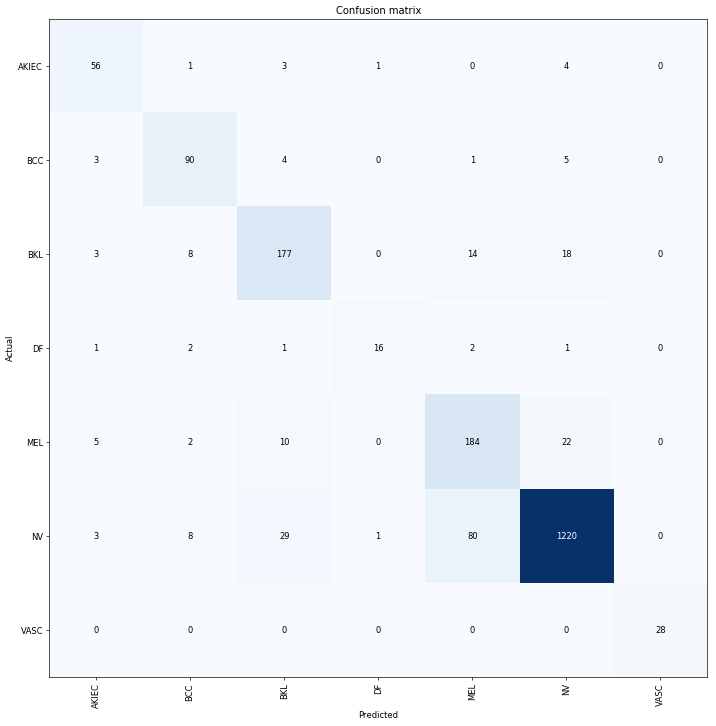

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('NV', 'MEL', 80),
 ('NV', 'BKL', 29),
 ('MEL', 'NV', 22),
 ('BKL', 'NV', 18),
 ('BKL', 'MEL', 14),
 ('MEL', 'BKL', 10),
 ('BKL', 'BCC', 8),
 ('NV', 'BCC', 8),
 ('BCC', 'NV', 5),
 ('MEL', 'AKIEC', 5),
 ('AKIEC', 'NV', 4),
 ('BCC', 'BKL', 4),
 ('AKIEC', 'BKL', 3),
 ('BCC', 'AKIEC', 3),
 ('BKL', 'AKIEC', 3),
 ('NV', 'AKIEC', 3),
 ('DF', 'BCC', 2),
 ('DF', 'MEL', 2),
 ('MEL', 'BCC', 2)]

In [24]:
learn.export()